In [1]:
import sys
import os

import requests
import xarray as xr
import netCDF4 as nc
from io import BytesIO
from datetime import datetime
import pytz


# Add the directory containing your modules to the system path
solarsteps_path=os.path.abspath('/dmidata/users/ikr/work/Weather2X/SolarSTEPS/')
if solarsteps_path not in sys.path:
    sys.path.append(solarsteps_path)
    
from Models.SolarSTEPS import SolarSTEPS
from Models.ProbabilisticAdvection import ProbabilisticAdvection
from pysteps.motion.lucaskanade import dense_lucaskanade
from compute_metrics import compute_ensemble_metrics
import numpy as np
from datetime import timedelta
import pvlib

from solar_functions import *

Pysteps configuration file found at: /dmidata/projects/weather2x/miniconda3/envs/pysteps/lib/python3.10/site-packages/pysteps/pystepsrc



In [2]:
def download_netcdf(url):
    response = requests.get(url)
    response.raise_for_status()
    return BytesIO(response.content)

In [3]:
BBOX_DK = "3,50,18,63"
BBOX_GHANA = "-6,3,5,12"
BBOX_REUNION = "53,-23,58,-19"
BBOX = BBOX_REUNION
WIDTH =500
HEIGHT = 500
CRS = "EPSG:4326"
FORMAT = "NetCDF4"

ens_members=40

In [4]:
base_url = "https://msgcpp-adaguc.knmi.nl/adaguc-server?"
variables = [
    "surface_downwelling_shortwave_flux_in_air",
    "surface_downwelling_shortwave_flux_in_air_assuming_clear_sky"
]

urls = [
    f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage={var}&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time=current"
    for var in variables
]


In [5]:
data = {}

for var, url in zip(variables, urls):
    netcdf_file = download_netcdf(url)
    ds = xr.open_dataset(netcdf_file)
    data[var] = ds


In [6]:
data['surface_downwelling_shortwave_flux_in_air']
data['surface_downwelling_shortwave_flux_in_air_assuming_clear_sky']

<xarray.Dataset>
Dimensions:  (x: 500, y: 500, time: 1)
Coordinates:
  * x        (x) float64 53.01 53.02 53.03 53.04 ... 57.97 57.98 57.99 58.0
  * y        (y) float64 -19.0 -19.01 -19.02 -19.03 ... -22.98 -22.99 -23.0
  * time     (time) datetime64[ns] 2024-11-13T13:30:00
Data variables:
    sds_cs   (time, y, x) float32 ...
    crs      |S1 ...
Attributes: (12/25)
    Conventions:                                              CF-1.6
    title:                                                    Cloud Physical ...
    institution:                                              Royal Netherlan...
    source:                                                   CPP_6.1
    history:                                                  Created by ADAG...
    references:                                               http://msgcpp.k...
    ...                                                       ...
    source_surface_emissivity:                                CIMMS
    subsatellite_longitude_nominal:                           0.0
    subsatellite_longitude_actual:                            0.023021912
    subsatellite_latitude_actual:                             -0.8073833
    adaguc_wcs_destgridspec:                                  width=500&heigh...
    software:                                                 ADAGUC WCS Serv...

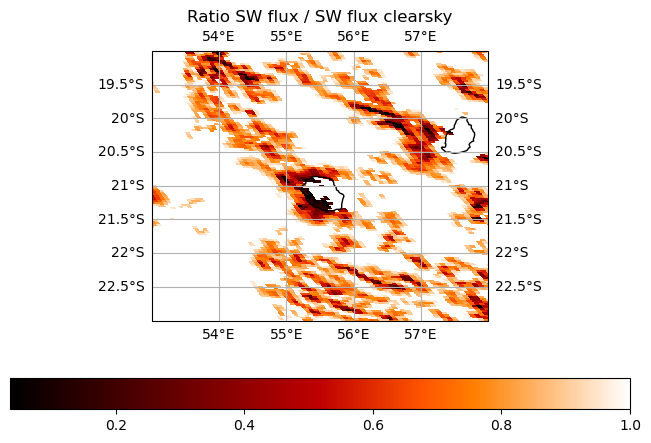

In [7]:
ratio = data['surface_downwelling_shortwave_flux_in_air'].sds/data['surface_downwelling_shortwave_flux_in_air_assuming_clear_sky'].sds_cs
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ratio.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='gist_heat', cbar_kwargs={'orientation': 'horizontal'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.gridlines(draw_labels=True)
plt.title('Ratio SW flux / SW flux clearsky')
plt.show()


In [8]:
# Get the current time dataset to find the latest available time
current_time_url = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage=surface_downwelling_shortwave_flux_in_air&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time=current"
netcdf_file = download_netcdf(current_time_url)
ds_current = xr.open_dataset(netcdf_file, engine='h5netcdf')

# Get the current time from the dataset
current_time = ds_current['time'].values[0]
current_time = np.datetime64(current_time)
current_time_str = current_time.astype('datetime64[m]').astype('O').strftime('%Y-%m-%dT%H:%M:%SZ')

# Calculate previous four 15-minute time steps
time_steps = [current_time - np.timedelta64(i * 15, 'm') for i in range(4)][::-1]

# Dictionary to hold datasets
data = {}

# Downloading data for each time step
for time in time_steps:
    time_str = time.astype('datetime64[m]').astype('O').strftime('%Y-%m-%dT%H:%M:%SZ')  # Format for URL
    for var in variables:
        url = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage={var}&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time={time_str}"
        netcdf_file = download_netcdf(url)
        ds = xr.open_dataset(netcdf_file, engine='h5netcdf')
        data[(var, time_str)] = ds


In [9]:
time_steps

[numpy.datetime64('2024-11-13T12:45:00.000000000'),
 numpy.datetime64('2024-11-13T13:00:00.000000000'),
 numpy.datetime64('2024-11-13T13:15:00.000000000'),
 numpy.datetime64('2024-11-13T13:30:00.000000000')]

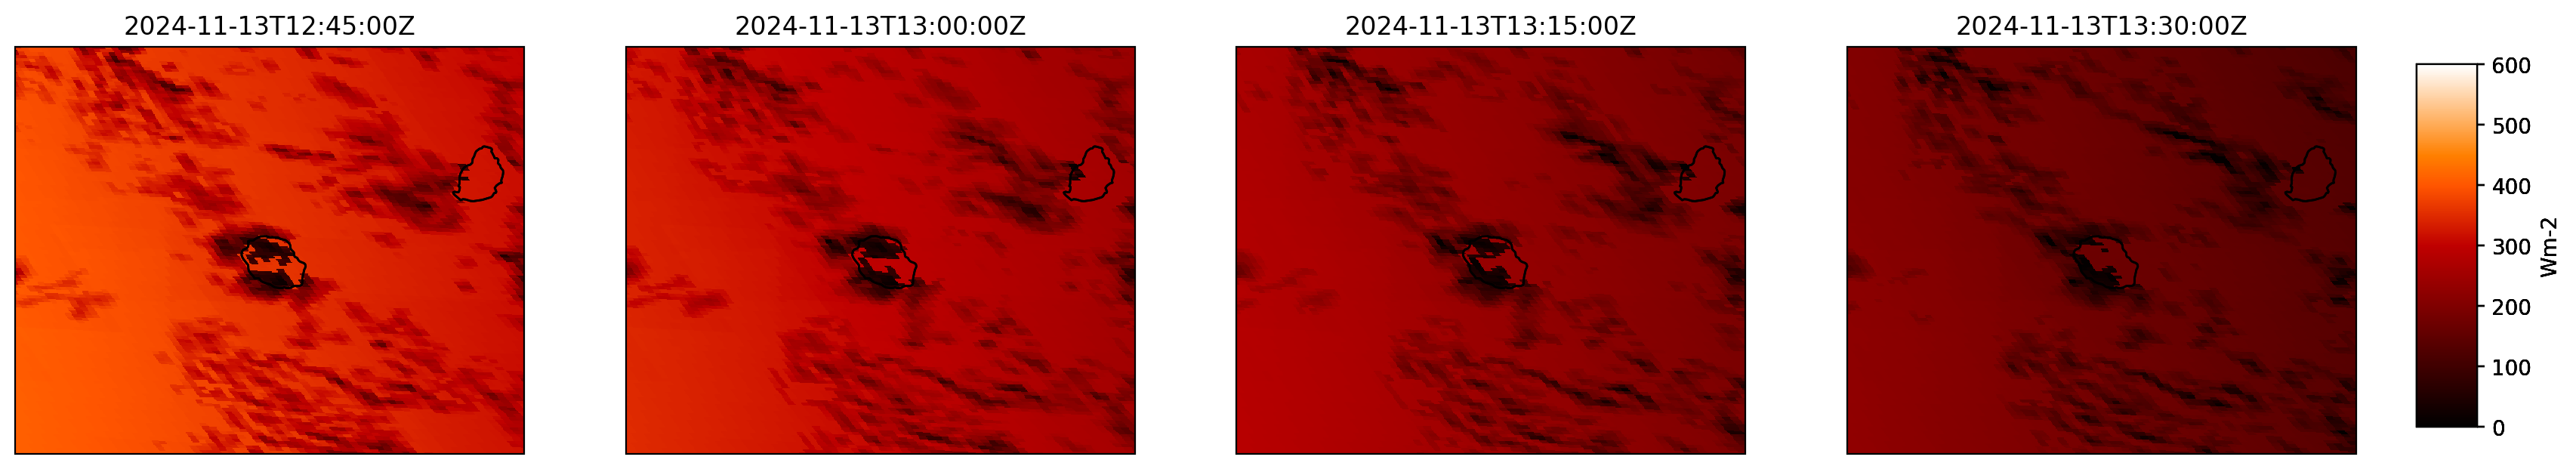

In [10]:
# Plotting all time steps
n_vars = len(variables)-1
n_times = len(time_steps)

accra_tz = pytz.timezone('Africa/Accra')


fig, axes = plt.subplots(n_vars, n_times, figsize=(n_times * 5, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=200)

for i, var in enumerate(variables):
    for j, time in enumerate(time_steps):
        
        
        local_time = time
        local_time_str = local_time.astype('datetime64[m]').astype('O').strftime('%Y-%m-%dT%H:%M:%SZ')
        ds = data[(var, local_time_str)]

        # Extract the appropriate variable based on the dataset
        if var == "surface_downwelling_shortwave_flux_in_air":
            plot_var = ds.sds
       #elif var == "surface_downwelling_shortwave_flux_in_air_assuming_clear_sky":
       #     plot_var = ds.sds_cs
        else:
            continue
        #print(plot_var)
        ax = axes[j]
        im = plot_var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='gist_heat', add_colorbar=False, vmin=0, vmax=600)

        ax.set_title(f"{local_time_str}")
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.COASTLINE)
        #ax.set_extent([8, 12.8, 54.5, 57.8], crs=ccrs.PlateCarree())

        # Adding a single colorbar for each row (variable)
        cbar_ax = fig.add_axes([0.92,0.3, 0.02, 0.4])  # Adjust position and size
        plt.colorbar(im, cax=cbar_ax, label="Wm-2")

#plt.tight_layout()
plt.show()

In [11]:
# List to hold numpy arrays of the ratio
ratio_arrays = []

# Base URL for the WCS requests
base_url = "https://msgcpp-adaguc.knmi.nl/adaguc-server?"

# Variables to retrieve
variable1 = "surface_downwelling_shortwave_flux_in_air"
variable2 = "surface_downwelling_shortwave_flux_in_air_assuming_clear_sky"

# Downloading data for each time step
for time in time_steps:
    time_str = time.astype('datetime64[m]').astype('O').strftime('%Y-%m-%dT%H:%M:%SZ')  # Format for URL

    # Download the first variable
    url1 = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage={variable1}&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time={time_str}"
    netcdf_file1 = download_netcdf(url1)
    ds1 = xr.open_dataset(netcdf_file1, engine='h5netcdf')
    sds_array1 = ds1.sds.values[0, :, :]  # Assuming the time dimension is the first

    # Download the second variable
    url2 = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage={variable2}&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time={time_str}"
    netcdf_file2 = download_netcdf(url2)
    ds2 = xr.open_dataset(netcdf_file2, engine='h5netcdf')
    sds_array2 = ds2.sds_cs.values[0, :, :]  # Assuming the time dimension is the first

    # Compute the ratio
    ratio = sds_array1 / sds_array2
    ratio_arrays.append(ratio)

# Convert list of arrays to a single numpy array with shape (time, y, x)
ratio_data = np.stack(ratio_arrays)

In [12]:
ratio_data.shape

(4, 500, 500)

In [13]:
# compute Lucas-12Kanade motion field
motion_field = dense_lucaskanade(ratio_data)

In [14]:
# initialize the models
pa = ProbabilisticAdvection(alpha=9.23, # variance of norm perturbation
                            beta=0.15, # k value for vonMises distribution for angle perturbation
                            ens_members=40,
                            return_motion_field=False)

solarsteps = SolarSTEPS(ar_order=1,
                        n_cascade_levels=9,
                        probmatching=True,
                        norm=True,
                        local=False,
                        noise_kwargs={'noise_win_size':90,
                                      'noise_std_win_size':30,
                                      'noise_method':'local-SSFT'},
                        norm_kwargs={'extra_normalization':True},
                        verbose=False
                        )

In [15]:
n_steps = len(ratio_data)

# compute probabilsitic advection forecast ensemble
pa_yhat = pa.maps_forecast(n_steps, ratio_data, motion_field)

# preprocess images in case of discontinuities
np.random.seed(0)
ratio_data += np.random.uniform(-0.00001, 0.00001, ratio_data.shape)

# compute SolarSTEPS forecast ensemble
ss_yhat = solarsteps.ensemble_forecast(ratio_data, motion_field,
                                       n_steps, seeds=np.arange(40))

0
1
2


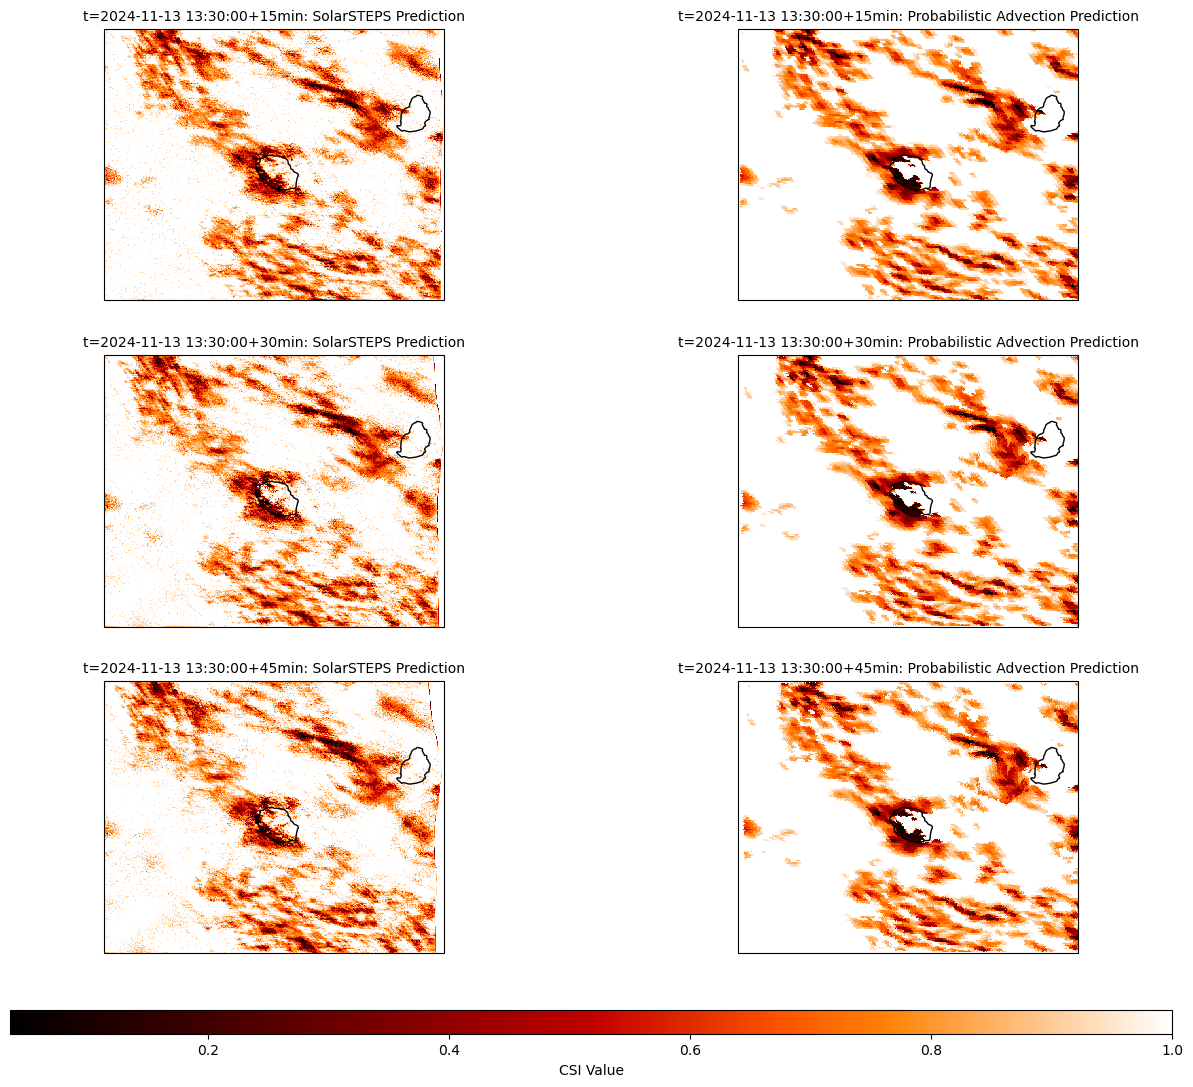

In [16]:
# Helper function to plot a single panel
def plot_panel(ax, data, title):
    #ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    lons = ds1.x.values
    lats = ds1.y.values
    mesh = ax.pcolormesh(lons, lats, data, cmap='gist_heat', transform=ccrs.PlateCarree())
    ax.set_title(title, fontsize=10)
    return mesh

# Define the time step (30 minutes)
time_step = timedelta(minutes=15)

# Start time for the first image
start_time = pd.to_datetime(time_steps[0])
forecast_time = pd.to_datetime(time_steps[-1])
# Number of columns (3 as per the example)
n_columns = 2

# Calculate the number of rows dynamically based on the number of steps
n_rows = (n_steps - 1)  # Ceiling division

# Plotting the panels
fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})
#axes = axes.flatten()  # Flatten the 2D array of axes

# Loop through each step and plot the panels
for step in range(0,n_steps-1):
    print(step)
    current_time = start_time + step * time_step
    time_label = f't={forecast_time}+{(step+1) * 15}min: '
    
    #mesh_output = plot_panel(axes[step // 2 * 3], ratio_data[step], f'{time_label}SARAH3 CSI Satellite Image')
    mesh_ss_yhat = plot_panel(axes[step,0], ss_yhat[0, step], f'{time_label}SolarSTEPS Prediction')
    mesh_pa_yhat = plot_panel(axes[step,1], pa_yhat[0, step], f'{time_label}Probabilistic Advection Prediction')



# Add a colorbar with the correct colormap
cbar = fig.colorbar(mesh_ss_yhat, ax=axes[:n_steps * 3], orientation='horizontal', pad=0.05, aspect=50, cmap='gist_heat')
cbar.set_label('CSI Value')

#plt.tight_layout()
plt.show()

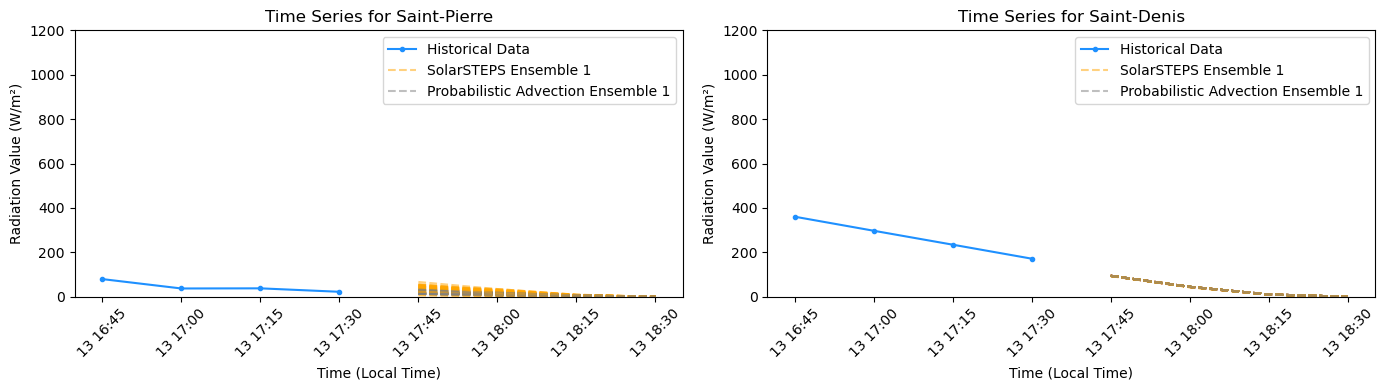

In [17]:


# Define function to download NetCDF file
def download_netcdf(url):
    response = requests.get(url)
    response.raise_for_status()
    return BytesIO(response.content)


# Define the locations for Accra and Kumasi
selected_locations = [
    {'LocationName': 'Saint-Pierre', 'Latitude': -21.3, 'Longitude': 55.4},
    {'LocationName': 'Saint-Denis', 'Latitude': -20.3, 'Longitude': 55.4}
]

# Assume ss_yhat and pa_yhat are already defined and contain the forecast data
n_steps = ss_yhat.shape[1]  # Number of forecast steps

# Get current time dataset
current_time_url = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage=surface_downwelling_shortwave_flux_in_air&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time=current"
netcdf_file = download_netcdf(current_time_url)
ds_current = xr.open_dataset(netcdf_file, engine='h5netcdf')

# Get the current time from the dataset
current_time = ds_current['time'].values[0]
current_time = np.datetime64(current_time)

# Time settings
time_step = timedelta(minutes=15)
start_time = current_time
output_times = pd.date_range(start=start_time + np.timedelta64(15, 'm'), periods=n_steps, freq='15min', tz='UTC')

# Prepare storage for forecast values
location_values_ss = {location['LocationName']: [] for location in selected_locations}
location_values_pa = {location['LocationName']: [] for location in selected_locations}

# Extract historical data (past satellite images)
historical_times = pd.date_range(end=start_time, periods=4, freq='15min', tz='UTC')

# Prepare storage for historical values
location_values_historical = {location['LocationName']: [] for location in selected_locations}

for location in selected_locations:
    for time in historical_times:
        historical_url = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage=surface_downwelling_shortwave_flux_in_air&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time={time.strftime('%Y-%m-%dT%H:%M:%SZ')}"
        try:
            netcdf_file = download_netcdf(historical_url)
            ds_historical = xr.open_dataset(netcdf_file, engine='h5netcdf')
            
            lon_idx = (np.abs(ds_historical.x.values - location['Longitude'])).argmin()
            lat_idx = (np.abs(ds_historical.y.values - location['Latitude'])).argmin()
            
            location_values_historical[location['LocationName']].append(ds_historical['sds'].values[0, lat_idx, lon_idx])
        except requests.HTTPError as e:
            print(f"Error fetching data for time {time}: {e}")

for step in range(n_steps):
    for location in selected_locations:
        lon_idx = (np.abs(ds1.x.values - location['Longitude'])).argmin()
        lat_idx = (np.abs(ds1.y.values - location['Latitude'])).argmin()

        loc = pvlib.location.Location(location['Latitude'], location['Longitude'])
        clear_sky_output = loc.get_clearsky(output_times, model='ineichen')
        clear_sky_ghi_output = clear_sky_output['ghi'].values[step]
        
        location_values_ss[location['LocationName']].append(ss_yhat[:, step, lat_idx, lon_idx] * clear_sky_ghi_output)
        location_values_pa[location['LocationName']].append(pa_yhat[:, step, lat_idx, lon_idx] * clear_sky_ghi_output)

# Convert forecast data to DataFrames
df_ss = pd.DataFrame(location_values_ss, index=output_times)
df_pa = pd.DataFrame(location_values_pa, index=output_times)
df_historical = pd.DataFrame(location_values_historical, index=historical_times)

# Convert UTC time to local time (Copenhagen time)
reunion_tz = pytz.timezone('Indian/Reunion')
output_times_reunion = output_times.tz_convert(reunion_tz)
historical_times_reunion = historical_times.tz_convert(reunion_tz)

# Create a 2-panel figure (one for each location)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, location in zip(axes, selected_locations):
    location_name = location['LocationName']

    # Plot historical data
    ax.plot(historical_times_reunion, df_historical[location_name], marker='.', label='Historical Data', color='dodgerblue')

    # Plot forecasts
   # ax.plot(output_times_accra, df_ss[location_name], label='SolarSTEPS Forecast', marker='o', color='orange')
    # ax.plot(output_times_accra, df_pa[location_name], label='Probabilistic Advection Forecast', linestyle='--', color='red')
    for i in range(df_ss[location_name].iloc[0].shape[0]):
        ss_ens_values = [ens[i] for ens in df_ss[location_name]]
        pa_ens_values = [ens[i] for ens in df_pa[location_name]]
        ax.plot(output_times_reunion, ss_ens_values, color='orange', alpha=0.5, linestyle='--', label=f'SolarSTEPS Ensemble {i+1}' if i == 0 else "")
        ax.plot(output_times_reunion, pa_ens_values, color='grey', alpha=0.5, linestyle='--', label=f'Probabilistic Advection Ensemble {i+1}' if i == 0 else "")

    # Add titles and labels
    ax.set_title(f'Time Series for {location_name}')
    ax.set_xlabel('Time (Local Time)')
    ax.set_ylabel('Radiation Value (W/m²)')
    ax.legend()
    ax.set_ylim(0,1200)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


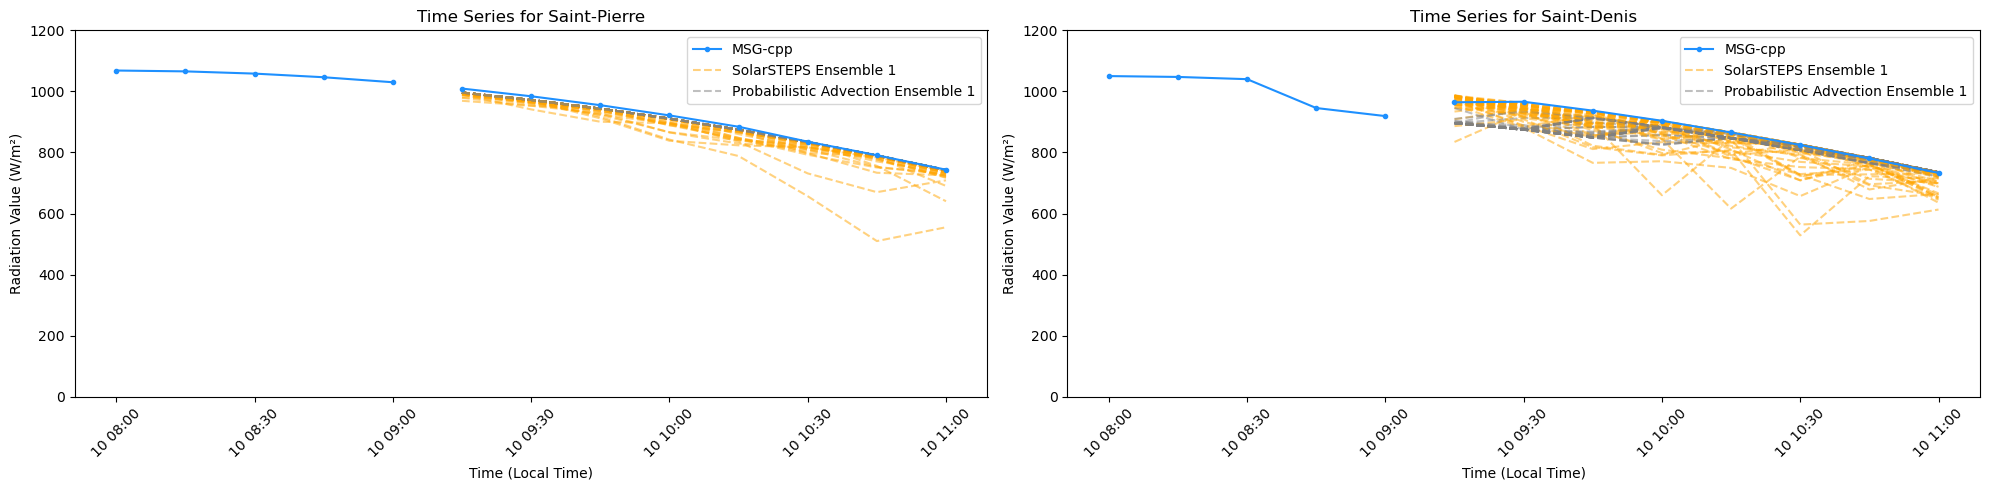

In [19]:
# Define function to download NetCDF file
def download_netcdf(url):
    response = requests.get(url)
    response.raise_for_status()
    return BytesIO(response.content)


# Define the locations for Accra and Kumasi
selected_locations = [
    {'LocationName': 'Saint-Pierre', 'Latitude': -21.3, 'Longitude': 55.4},
    {'LocationName': 'Saint-Denis', 'Latitude': -20.3, 'Longitude': 55.4}
]

# Define a historical period for verification
historical_start_time = datetime(2024, 11, 10, 8, 00)  # Example past date and time
historical_end_time = historical_start_time + timedelta(hours=1)  # Example duration of 2 hours
historical_times = pd.date_range(start=historical_start_time, end=historical_end_time, freq='15min', tz='UTC')





# Prepare storage for historical values
location_values_historical = {location['LocationName']: [] for location in selected_locations}
ratio_arrays = []
ratio_arrays_output = []

# Downloading data for each historical time step
for time in historical_times:
    time_str = time.strftime('%Y-%m-%dT%H:%M:%SZ')

    # Download the surface downwelling flux data
    url1 = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage={variable1}&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time={time_str}"
    netcdf_file1 = download_netcdf(url1)
    ds1 = xr.open_dataset(netcdf_file1, engine='h5netcdf')
    sds_array1 = ds1.sds.values[0, :, :]  # Assuming the time dimension is the first

    # Download the clear sky data
    url2 = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage={variable2}&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time={time_str}"
    netcdf_file2 = download_netcdf(url2)
    ds2 = xr.open_dataset(netcdf_file2, engine='h5netcdf')
    sds_array2 = ds2.sds_cs.values[0, :, :]  # Assuming the time dimension is the first

    # Compute the ratio
    ratio = sds_array1 / sds_array2
    ratio_arrays.append(ratio)

    # Extracting historical data for locations
    for location in selected_locations:
        lon_idx = (np.abs(ds1.x.values - location['Longitude'])).argmin()
        lat_idx = (np.abs(ds1.y.values - location['Latitude'])).argmin()
        location_values_historical[location['LocationName']].append(sds_array1[lat_idx, lon_idx])

# Compute forecasts based on ratio_data and motion_field
ratio_data = np.array(ratio_arrays)
n_steps = 8

# Assuming motion_field is already defined
# compute probabilistic advection forecast ensemble
pa_yhat = pa.maps_forecast(n_steps, ratio_data, motion_field)

# preprocess images in case of discontinuities
np.random.seed(0)
ratio_data += np.random.uniform(-0.00001, 0.00001, ratio_data.shape)

# compute SolarSTEPS forecast ensemble
ss_yhat = solarsteps.ensemble_forecast(ratio_data, motion_field, n_steps, seeds=np.arange(ens_members))

# Time settings for forecast data (starting from an earlier time)
forecast_start_time = historical_end_time  # Forecast starts right after the historical data ends
output_times = pd.date_range(start=np.datetime64(forecast_start_time) + np.timedelta64(15, 'm'), periods=n_steps, freq='15min', tz='UTC')

# Prepare storage for forecast values
location_values_ss = {location['LocationName']: [] for location in selected_locations}
location_values_pa = {location['LocationName']: [] for location in selected_locations}

location_values_output = {location['LocationName']: [] for location in selected_locations}

for step in range(n_steps):
    for location in selected_locations:
        lon_idx = (np.abs(ds1.x.values - location['Longitude'])).argmin()
        lat_idx = (np.abs(ds1.y.values - location['Latitude'])).argmin()

        loc = pvlib.location.Location(location['Latitude'], location['Longitude'])
        clear_sky_output = loc.get_clearsky(output_times, model='ineichen')
        clear_sky_ghi_output = clear_sky_output['ghi'].values[step]
        
        location_values_ss[location['LocationName']].append(ss_yhat[:, step, lat_idx, lon_idx] * clear_sky_ghi_output)
        location_values_pa[location['LocationName']].append(pa_yhat[:, step, lat_idx, lon_idx] * clear_sky_ghi_output)

# Convert forecast data to DataFrames
df_ss = pd.DataFrame(location_values_ss, index=output_times)
df_pa = pd.DataFrame(location_values_pa, index=output_times)
df_historical = pd.DataFrame(location_values_historical, index=historical_times)



# Downloading data for each already-happened "future" time step
for time in output_times:
    time_str = time.strftime('%Y-%m-%dT%H:%M:%SZ')

    # Download the surface downwelling flux data
    url1 = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage={variable1}&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time={time_str}"
    netcdf_file1 = download_netcdf(url1)
    ds1 = xr.open_dataset(netcdf_file1, engine='h5netcdf')
    sds_array1_output = ds1.sds.values[0, :, :]  # Assuming the time dimension is the first

    # Download the clear sky data
    url2 = f"{base_url}dataset=msgrt&service=wcs&request=getcoverage&coverage={variable2}&FORMAT={FORMAT}&CRS={CRS}&BBOX={BBOX}&WIDTH={WIDTH}&HEIGHT={HEIGHT}&time={time_str}"
    netcdf_file2 = download_netcdf(url2)
    ds2 = xr.open_dataset(netcdf_file2, engine='h5netcdf')
    sds_array2_output = ds2.sds_cs.values[0, :, :]  # Assuming the time dimension is the first

    # Compute the ratio
    ratio_output = sds_array1 / sds_array2
    ratio_arrays_output.append(ratio_output)

    # Extracting historical data for locations
    for location in selected_locations:
        lon_idx = (np.abs(ds1.x.values - location['Longitude'])).argmin()
        lat_idx = (np.abs(ds1.y.values - location['Latitude'])).argmin()
        location_values_output[location['LocationName']].append(sds_array1_output[lat_idx, lon_idx])


df_output = pd.DataFrame(location_values_output, index=output_times)



# Convert UTC time to local time (Accra time)
accra_tz = pytz.timezone('Africa/Accra')
output_times_accra = output_times.tz_convert(accra_tz)
historical_times_accra = historical_times.tz_convert(accra_tz)

# Create a 4-panel figure (one for each location)
fig, axes = plt.subplots(1, len(selected_locations), figsize=(20, 5))

for ax, location in zip(axes, selected_locations):
    location_name = location['LocationName']

    # Plot historical data
    ax.plot(historical_times_accra, df_historical[location_name], marker='.', label='MSG-cpp', color='dodgerblue')

    # Plot forecasts
    #ax.plot(output_times_accra, df_ss[location_name], label='SolarSTEPS Forecast', linestyle='--', color='orange')
    #ax.plot(output_times_accra, df_pa[location_name], label='Probabilistic Advection Forecast', linestyle='--', color='grey')
    
    # Plot ensemble forecasts
    for i in range(df_ss[location_name].iloc[0].shape[0]):
        ss_ens_values = [ens[i] for ens in df_ss[location_name]]
        pa_ens_values = [ens[i] for ens in df_pa[location_name]]
        ax.plot(output_times.tz_convert(accra_tz), ss_ens_values, color='orange', alpha=0.5, linestyle='--', label=f'SolarSTEPS Ensemble {i+1}' if i == 0 else "")
        ax.plot(output_times.tz_convert(accra_tz), pa_ens_values, color='grey', alpha=0.5, linestyle='--', label=f'Probabilistic Advection Ensemble {i+1}' if i == 0 else "")

    
    #Plot satellite data of what happened
    ax.plot(output_times_accra, df_output[location_name], marker='.', color='dodgerblue')

    # Add titles and labels
    ax.set_title(f'Time Series for {location_name}')
    ax.set_xlabel('Time (Local Time)')
    ax.set_ylabel('Radiation Value (W/m²)')
    ax.set_ylim(0,1200)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()